In [1]:
# Header

import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy import units as u
from astropy.table import Table
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_lines
from specutils.fitting.continuum import fit_continuum
from astropy.nddata.nduncertainty import StdDevUncertainty
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rc

In [2]:
# rc params

mult = 1
matplotlib.rcParams.update({'font.size': 15*mult})
matplotlib.rcParams['legend.fontsize'] = 15*mult
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.labelsize'] = 15*mult
matplotlib.rcParams['ytick.labelsize'] = 15*mult
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.left'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['axes.labelsize'] = 15*mult
matplotlib.rcParams['text.usetex'] = True

In [3]:
# RF wavelengths taken from NIST (Ritz wavelength air)

Hb_rf = 4861.333
FeII4924_rf = 4924.3013  
OIII4959_rf = 4958.911 
OIII5007_rf = 5006.843
FeII5018_rf = 5018.4358
Ha_rf = 6562.819
NII6548_rf =  6548.05
NII6583_rf = 6583.45 
HeI6678_rf = 6678.151
SII6716_rf =  6715.773
SII6731_rf = 6730.816

dict_rf = {  'Hb': 4861.333,
            'FeII4924': 4924.3013,  
            'OIII4959': 4958.911, 
            'OIII5007': 5006.843,
            'FeII5018': 5018.4358,
            'Ha': 6562.819,
            'NII6548':  6548.05,
            'NII6583': 6583.45, 
            'HeI6678': 6678.151,
            'SII6716':  6715.773,
            'SII6731': 6730.816,
         }

In [4]:
class Fit_Spectrum():
    def __init__(self,x,y,dy,param_init=None, param_init_file=None):
        
        self.wvl_full = x
        self.spec_full = y
        self.err_full = dy
        
        self.fit_range_Hb = SpectralRegion(4750*u.Angstrom, 5100*u.Angstrom)
        self.fit_range_Ha = SpectralRegion(6500*u.Angstrom, 6650*u.Angstrom)
        self.fit_range = [self.fit_range_Hb+ self.fit_range_Ha]
        
        self.mask_Hb = (self.wvl_full>self.fit_range_Hb.bounds[0].value) & (self.wvl_full<self.fit_range_Hb.bounds[1].value)
        self.mask_Ha = (self.wvl_full>self.fit_range_Ha.bounds[0].value) & (self.wvl_full<self.fit_range_Ha.bounds[1].value)

        self.contrf_Hb = {'blu':[4750,4755], 'red':[5080,5090]}
        self.contrf_Ha = {'blu':[6430,6435], 'red':[6650,6655]}
        
        # cropping
        self.wave, self.eline, self.cont, self.err = self.crop()

        
        self.elines = [ 
                        #H Hb region
                        'Hb_core','OIII4959_core', 'OIII5007_core', 
                        'Hb_medium', 'FeII4924_medium','FeII5018_medium',
                        'Hb_broad', 'FeII4924_broad', 'FeII5018_broad',
                        'Hb_wing', 'OIII4959_wing', 'OIII5007_wing',
                        # Ha region
                        'Ha_core', 'NII6548_core', 'NII6583_core', 'SII6716_core', 'SII6731_core', 
                        'Ha_medium',
                        'Ha_broad',
                        'Ha_wing'
                        #'HeI6678_broad'
                      ]
    
    
        maxflux_Ha = np.nanmax(self.eline)
        
        self.v_core = -140.3
        self.v_wing = -560
            
        if param_init_file:
            hdul=fits.open(param_init_file)
            table = Table(hdul[1].data)
            
            
            self.param_init = {
                    # Hb region
                    'Hb_core' :    table['Hb_core'],                        # 0
                    'OIII4959_core' : table['OIII4959_core'],                     # 1
                    'OIII5007_core':  table['OIII5007_core'],                     # 2

                    'Hb_medium':   table['Hb_medium'],                      # 3
                    'FeII4924_medium':table['FeII4924_medium'],                   # 4
                    'FeII5018_medium':table['FeII5018_medium'],                   # 5

                    'Hb_broad':    table['Hb_broad'],                       # 6
                    'FeII4924_broad': table['FeII4924_broad'],                    # 7
                    'FeII5018_broad': table['FeII5018_broad'],                    # 8

                    'Hb_wing':     [0.1*maxflux_Ha,4855, 3.53],                        # 9
                    'OIII4959_wing':  table['OIII4959_wing'],                     # 10
                    'OIII5007_wing':  table['OIII5007_wing'],                     # 11
                                
                    # Ha region
                    'Ha_core' :                                             # 12
                    [maxflux_Ha*.4, Ha_rf+Ha_rf*self.v_core/3e5, table['Hb_core'][2] *Ha_rf/Hb_rf],
                    'NII6548_core' :                                                   # 13
                    [maxflux_Ha*0.1, NII6548_rf+NII6548_rf*self.v_core/3e5,table['Hb_core'][2]],
                    'NII6583_core' :                                                   # 14
                    [maxflux_Ha*0.1, NII6583_rf+NII6583_rf*self.v_core/3e5,table['Hb_core'][2]],
                    'SII6716_core' :                                                   # 15
                    [maxflux_Ha*0, SII6716_rf-1,table['Hb_core'][2]],
                    'SII6731_core' :                                                   # 16
                    [maxflux_Ha*0, SII6731_rf-1,table['Hb_core'][2]],
 
                    'Ha_medium':                                              # 17
                    [maxflux_Ha*.2, Ha_rf, table['Hb_medium'][2] *Ha_rf/Hb_rf],
                    'Ha_broad':                                               # 18
                    [maxflux_Ha*.2, Ha_rf, table['Hb_broad'][2] *Ha_rf/Hb_rf],
                    'Ha_wing':                                                # 19
                    [maxflux_Ha*.2, Ha_rf+Ha_rf*(self.v_wing/3e5),table['Hb_wing'][2] *Ha_rf/Hb_rf],
                
                    'HeI6678_broad':                                              # 20
                    [maxflux_Ha*.02, HeI6678_rf,table['Hb_broad'][2]],
                
                                }
            
        elif param_init: 
            self.param_init=param_init
        else: 
            raise ValueError('Provide either param_init or param_init_file')
            
        self.eline_models = self.setup_eline_models(self.param_init)
            
            
        ##############   Kinematic Coupling  #################
        
        #                                    Line Ratios
        
        # Hb region
        self.eline_models.OIII5007_core.amplitude.tied =   self.tie_OIII5007_core_amplitude
        self.eline_models.OIII5007_wing.amplitude.tied =   self.tie_OIII5007_wing_amplitude
        self.eline_models.FeII5018_medium.amplitude.tied = self.tie_FeII5018_medium_amplitude
        self.eline_models.FeII5018_broad.amplitude.tied =  self.tie_FeII5018_broad_amplitude
        
        # Ha region
        self.eline_models.NII6583_core.amplitude.tied = self.tie_NII6583_core_amplitude
        
        #                                    Velocities
        
        # Hb region
        #self.eline_models.Hb_core.mean.tied =     self.tie_Hb_pos
        self.eline_models.OIII4959_core.mean.tied =    self.tie_OIII4959_core_pos
        self.eline_models.OIII5007_core.mean.tied =    self.tie_OIII5007_core_pos
        self.eline_models.FeII4924_medium.mean.tied =  self.tie_FeII4924_medium_pos
        self.eline_models.FeII5018_medium.mean.tied =  self.tie_FeII5018_medium_pos
        self.eline_models.FeII4924_broad.mean.tied =   self.tie_FeII4924_broad_pos
        self.eline_models.FeII5018_broad.mean.tied =   self.tie_FeII5018_broad_pos
        self.eline_models.OIII4959_wing.mean.tied =    self.tie_OIII4959_wing_pos
        self.eline_models.OIII5007_wing.mean.tied =    self.tie_OIII5007_wing_pos
        self.eline_models.Hb_wing.mean.tied = self.tie_Hb_wing_pos
        # Ha region
        self.eline_models.Ha_core.mean.tied =     self.tie_Ha_core_pos
        self.eline_models.NII6548_core.mean.tied =     self.tie_NII6548_core_pos
        self.eline_models.NII6583_core.mean.tied =     self.tie_NII6583_core_pos
        self.eline_models.SII6716_core.mean.tied =     self.tie_SII6716_core_pos
        self.eline_models.SII6731_core.mean.tied =     self.tie_SII6731_core_pos
        #self.eline_models.Ha_medium.mean.tied =   self.tie_Ha_medium_pos
        #self.eline_models.Ha_broad.mean.tied =    self.tie_Ha_broad_pos
        #self.eline_models.Ha_wing.mean.tied =      self.tie_Ha_wing_pos
        #self.eline_models.HeI6678_broad.mean.tied =   self.tie_HeI6678_broad_pos
        
        
        #                                    Dispersions
       
        # Hb region
        self.eline_models.OIII4959_core.stddev.tied =    self.tie_OIII4959_core_stddev
        self.eline_models.OIII5007_core.stddev.tied =    self.tie_OIII5007_core_stddev
        self.eline_models.FeII4924_medium.stddev.tied =  self.tie_FeII4924_medium_stddev
        self.eline_models.FeII4924_broad.stddev.tied =   self.tie_FeII4924_broad_stddev
        self.eline_models.FeII5018_medium.stddev.tied =  self.tie_FeII5018_medium_stddev
        self.eline_models.FeII5018_broad.stddev.tied =   self.tie_FeII5018_broad_stddev
        self.eline_models.OIII4959_wing.stddev.tied =    self.tie_OIII4959_wing_stddev
        self.eline_models.OIII5007_wing.stddev.tied =    self.tie_OIII5007_wing_stddev
        # Ha region
        #self.eline_models.Ha_core.stddev.tied = self.tie_Ha_core_stddev
        #self.eline_models.NII6548_core.stddev.tied =     self.tie_NII6548_core_stddev
        self.eline_models.NII6548_core.stddev.tied =     self.tie_NII6548_core_stddev
        self.eline_models.SII6716_core.stddev.tied =     self.tie_SII6716_core_stddev
        self.eline_models.SII6731_core.stddev.tied =     self.tie_SII6731_core_stddev
        #self.eline_models.Ha_medium.stddev.tied =   self.tie_Ha_medium_stddev
        #self.eline_models.Ha_broad.stddev.tied =    self.tie_Ha_broad_stddev
        #self.eline_models.Ha_wing.stddev.tied =      self.tie_Ha_wing_stddev
        self.eline_models.HeI6678_broad.stddev.tied =    self.tie_HeI6678_broad_stddev
        
        
    #                                        Line Ratios
    
    # note that we want to couple the fluxes (amplitude * stddev), 
    # not the amplitudes! However, since the stddevs are coupled 
    # this equivalent to coupling fluxes
    
    # Ha region
    def tie_OIII5007_core_amplitude(self,model):   return 3*model.amplitude_1     #*(model.stddev_1/model.stddev_2)# couple to OIII4959
    def tie_OIII5007_wing_amplitude(self,model):   return 3*model.amplitude_10    #*(model.stddev_10/model.stddev_11) # couple to OIII4959_wing
    def tie_FeII5018_medium_amplitude(self,model): return 1.29*model.amplitude_4  #*(model.stddev_4/model.stddev_5) # couple to FeII4924_medium
    def tie_FeII5018_broad_amplitude(self,model):  return 1.29* model.amplitude_7 #*(model.stddev_7/model.stddev_8) # couple to FeII4924_broad

    # Ha region
    def tie_NII6583_core_amplitude(self,model): return 3*model.amplitude_13  

    
    #                                        Velocities
    
    # Hb region
    def tie_Hb_pos(self,model): Hb_rf+Hb_rf*(self.v_core/3e5) # couple to rest-frame?
    def tie_OIII4959_core_pos(self,model):   return model.mean_0 * (OIII4959_rf/Hb_rf) # to Hb_core
    def tie_OIII5007_core_pos(self,model):   return model.mean_1 * (OIII5007_rf/OIII4959_rf) # to Hb_core
    def tie_FeII4924_medium_pos(self,model): return model.mean_3 * (FeII4924_rf/Hb_rf) # to Hb_medium
    def tie_FeII5018_medium_pos(self,model): return model.mean_3 * (FeII5018_rf/Hb_rf) # to Hb_medium
    def tie_FeII4924_broad_pos(self,model):  return model.mean_6 * (FeII4924_rf/Hb_rf) # to Hb_broad
    def tie_FeII5018_broad_pos(self,model):  return model.mean_6 * (FeII5018_rf/Hb_rf) # to Hb_broad
    def tie_OIII4959_wing_pos(self,model):  return OIII4959_rf+OIII4959_rf*(self.v_wing/3e5) # to Hb_wing
    def tie_OIII5007_wing_pos(self,model):   return model.mean_10 * (OIII5007_rf/OIII4959_rf) # to Hb_wing
    def tie_Hb_wing_pos(self,model):   return Hb_rf+Hb_rf*(self.v_wing/3e5) # to Hb_wing
    
    # Ha region
    def tie_Ha_core_pos(self,model):     return Ha_rf+Ha_rf*(self.v_core/3e5)
    def tie_NII6548_core_pos(self,model):    return NII6548_rf+NII6548_rf*(self.v_core/3e5)
    def tie_NII6583_core_pos(self,model):    return model.mean_13 * NII6583_rf/NII6548_rf
    def tie_SII6716_core_pos(self,model):    return model.mean_12 * SII6716_rf/Ha_rf
    def tie_SII6731_core_pos(self,model):    return model.mean_15 * SII6731_rf/SII6716_rf
    def tie_Ha_medium_pos(self,model):   return model.mean_3 * Ha_rf/Hb_rf
    def tie_Ha_broad_pos(self,model):    return model.mean_6 * Ha_rf/Hb_rf
    def tie_Ha_wing_pos(self,model):     return Ha_rf+Ha_rf*(self.v_wing/3e5)
    def tie_HeI6678_broad_pos(self,model):   return model.mean_6 * HeI6678_rf/Hb_rf
    
    
    #                                        Dispersions
    
    # Hb region
    def tie_OIII4959_core_stddev(self,model):   return model.stddev_0*(model.mean_1/model.mean_0)  # to Hb_core
    def tie_OIII5007_core_stddev(self,model):   return model.stddev_1*(model.mean_2/model.mean_1)  # to Hb narrow
    def tie_FeII4924_medium_stddev(self,model): return model.stddev_3*(model.mean_4/model.mean_3)  # to Hb_medium
    def tie_FeII5018_medium_stddev(self,model): return model.stddev_3*(model.mean_5/model.mean_3)  # to Hb medium
    def tie_FeII4924_broad_stddev(self,model):  return model.stddev_6*(model.mean_7/model.mean_6)  # to Hb_broad
    def tie_FeII5018_broad_stddev(self,model):  return model.stddev_6*(model.mean_8/model.mean_6)  # to Fe II broad
    def tie_OIII4959_wing_stddev(self,model):   return model.stddev_9*(model.mean_10/model.mean_9) # to Hb_wing
    def tie_OIII5007_wing_stddev(self,model):   return model.stddev_10*(model.mean_11/model.mean_10) # to Hb_wing
    # Ha region
    #def tie_Ha_core_stddev(self,model):   return model.stddev_0*(model.mean_12/model.mean_0)
    def tie_NII6548_core_stddev(self,model):  return model.stddev_12*(model.mean_13/model.mean_12)
    def tie_NII6583_core_stddev(self,model):  return model.stddev_13*(model.mean_14/model.mean_13)
    def tie_SII6716_core_stddev(self,model):  return model.stddev_12*(model.mean_15/model.mean_12)
    def tie_SII6731_core_stddev(self,model):  return model.stddev_15*(model.mean_16/model.mean_15)
    #def tie_Ha_medium_stddev(self,model): return model.stddev_3*(model.mean_17/model.mean_3)
    #def tie_Ha_broad_stddev(self,model):  return model.stddev_6*(model.mean_18/model.mean_6)
    #def tie_Ha_wing_stddev(self,model):   return model.stddev_9*(model.mean_19/model.mean_9)
    def tie_HeI6678_broad_stddev(self,model): return model.stddev_16*(model.mean_18/model.mean_16)
    
    
            ##############################################
    
    
    def subtract_continuum(self,wvl,spectrum,cont_lim):
        
        select_cont = np.zeros(wvl.shape).astype(bool)
        for i in cont_lim:
            select_cont = select_cont + ((wvl> cont_lim[i][0]) & 
                                         (wvl< cont_lim[i][1])
                                        )
        # fit continuum with linear model
        fit = fitting.LinearLSQFitter() 
        line_init=models.Polynomial1D(degree=1) 
        cont_model = fit(line_init, wvl[select_cont], spectrum[select_cont])
        cont = cont_model(wvl) 

        eline = spectrum - cont
        eline_norm = eline/np.nansum(eline)
        
        return eline, cont
    
    def crop(self):
        
        eline_Hb, cont_Hb = self.subtract_continuum(self.wvl_full, self.spec_full, self.contrf_Hb)
        eline_Ha, cont_Ha = self.subtract_continuum(self.wvl_full, self.spec_full, self.contrf_Ha)
        
        wave_stack = np.append(self.wvl_full[self.mask_Hb], self.wvl_full[self.mask_Ha])
        eline_stack = np.append(eline_Hb[self.mask_Hb], eline_Ha[self.mask_Ha])
        cont_stack = np.append(cont_Hb[self.mask_Hb], cont_Ha[self.mask_Ha])
        err_stack = np.append(self.err_full[self.mask_Hb], self.err_full[self.mask_Ha])
        
        return wave_stack, eline_stack, cont_stack, err_stack
    

    
    def setup_eline_models(self, param):
        
        eline_models = type('', (), {})() # empty object
        
        for i in self.param_init:
            gauss = models.Gaussian1D(param[i][0]*u.erg/u.s/u.cm**2/u.Angstrom, param[i][1]*u.Angstrom,param[i][2]*u.Angstrom)
            setattr(eline_models, i, gauss)
        
        return eline_models
    
    def setup_model_init(self, elines, eline_models):
        
        # from all emission lines found in the QSO spectrum
        # this function kinematically ties the components that stem from the same region
        
        # get all eline_models in component
        basemodels = np.full(len(elines), models.Gaussian1D())
        for idx, eline in enumerate(elines):
            basemodels[idx] = getattr(self.eline_models, eline)

        # compound model
        for idx in range(len(basemodels))[1:]: # add all models to first element in array
            basemodels[0] += basemodels[idx]
        
        self.model_init = basemodels[0]
        
        for i in self.model_init:
            i.amplitude.min = 0
        
        return None
    
    def run(self):
        
        # fits single the AGN spectrum
        
        spectrum = Spectrum1D(flux=self.eline*u.erg/u.s/u.cm**2/u.Angstrom, spectral_axis=self.wave*u.Angstrom, uncertainty = StdDevUncertainty(self.err))
     
        model = fit_lines(spectrum, self.model_init, window=self.fit_range, weights='unc')
        model_spectrum = model(self.wave*u.Angstrom)
        
        self.model = model
        self.model_spectrum = model_spectrum
        
        return None
    
    def run_mc(self,nmcmc=30):
        
        # MC error estimation for
        # AGN fit parameters
        
        param = np.zeros([nmcmc,self.model_init.parameters.shape[0]])

        for idx in range(nmcmc):
            ynew = np.random.normal(self.eline,self.err)
            newspectrum = Spectrum1D(flux=ynew*u.erg/u.s/u.cm**2/u.Angstrom, spectral_axis=self.wave*u.Angstrom, uncertainty = StdDevUncertainty(self.err))
            newmodel = fit_lines(newspectrum, self.model_init, window=self.fit_range, weights='unc')
            param[idx] = newmodel.parameters
            
        median = type('', (), {})()
        stddev = type('', (), {})()
        
        for idx,parameter in enumerate(self.model_init.param_names):
            setattr(median, parameter, np.nanmedian(param[:,idx]))
            setattr(stddev, parameter, np.nanstd(param[:,idx]))
        
        self.bestfit = type('', (), {})()
        self.bestfit.median = median
        self.bestfit.error = stddev
        
        return None
    
    def print(self):
        
        # this function prints the best fit results
        
        # first, deconvolve velocities with HST STIS MAMA 
        # resolution https://hst-docs.stsci.edu/stisihb/chapter-13-spectroscopic-
        # reference-material/13-6-line-spread-functions/first-order-line-spread-functions
        
        # config: 52X0.5, 1200A: 1.7px
        
        instr = (1.7*0.029) # FWHM [px] * arcsec/px
        sigma = (1.7*0.029) /2.35 # FWHM [px] * arcsec/px
        instr = 3e5 * sigma/1200 # in kms-1

        print('comp. \t\t\t\t  mean λ [A] \t disp σ [A]     A [ergs-1cm-2A-1]     F [ergs-1cm-2]')
              
        for idx,eline in enumerate(self.elines):
              print(' %1s \t %16s \t %.1f \u00B1 %.1f \t %.2f \u00B1 %.2f \t %2.2f \u00B1 %2.2f \t %.2f \u00B1 %.2f  '
                    %(str(idx),
                      eline,
                      getattr(self.bestfit.median, 'mean_'+str(idx)),
                      getattr(self.bestfit.error,  'mean_'+str(idx)),
                      getattr(self.bestfit.median, 'stddev_'+str(idx)),
                      getattr(self.bestfit.error,  'stddev_'+str(idx)),
                      getattr(self.bestfit.median, 'amplitude_'+str(idx)),
                      getattr(self.bestfit.error,  'amplitude_'+str(idx)),
                      # flux
                      getattr(self.bestfit.median, 'amplitude_'+str(idx))*\
                      getattr(self.bestfit.median,  'stddev_'+str(idx)),
                      np.sqrt( (getattr(self.bestfit.error,  'amplitude_'+str(idx))* \
                                getattr(self.bestfit.median,  'stddev_'+str(idx)))**2
                              +(getattr(self.bestfit.median,  'amplitude_'+str(idx))* \
                                getattr(self.bestfit.error,  'stddev_'+str(idx)))**2
                             )
                     )
                   )
                
        
        print('\n')
        print('%15s %15s %15s ' %('component ','v [kms-1]', 'σ [kms-1]'))
        print('%.50s' %('-'*50))

        for idx,component in enumerate(self.elines):

            eline = component.split('_')[0]

            # velocity
            v = (getattr(self.bestfit.median, 'mean_'+str(idx)) - dict_rf[eline])/dict_rf[eline] * 3e5
            v_err = getattr(self.bestfit.error, 'mean_'+str(idx))/dict_rf[eline] * 3e5

            # dispersion [deconvolve with MUSE reoslution (2.5 A)] 
            res =2.5 # [A]
            stddev = getattr(self.bestfit.median, 'stddev_'+str(idx)) # output from fit
            disp = np.sqrt(stddev**2 - res**2)/dict_rf[eline] * 3e5
            disp_err = getattr(self.bestfit.error, 'stddev_'+str(idx))/dict_rf[eline] * 3e5


            print('%2s %7s %10s %8.0f \u00B1 %4.0f  %8.0f \u00B1 %2.0f'\
                  %(idx, component.split('_')[1], eline, 
                    v,  v_err,disp, disp_err))
            
            
    
    def write_eline_table(self, output=None):
        
        # saves eline parameters in .fits table
        if output==None: raise ValueError('specify path to write output file!') 
        
        t = Table([['amplitude', 'mean', 'stddev'],
                   *[(self.model[i].parameters) for i in range(len(self.elines))]],
                    names=('parameter', *self.elines)
                  )
            
        t.write(output, overwrite=True)
        
    def write_OIIIwing_spec(self, output=None):
        
        # subtract all components but OIII wing
        # write residual spectrum to output
        
        if output==None: raise ValueError('specify path to write output file!')
            
        ELmodel =   self.model[0] + self.model[3] + self.model[4] + \
                    self.model[5] + self.model[6] +  self.model[7] + \
                    self.model[8] + self.model[9] 
        ELmodel_spectrum = ELmodel(self.wvl_full*u.Angstrom)
        
        OIII_residuals = np.array(self.spec_full) - ELmodel_spectrum.value
        
        t = Table( [self.wvl_full, OIII_residuals, self.err_full],names= ['wave','flux', 'error'])
        
        t.write(output, overwrite=True)

In [5]:
class Plot(Fit_Spectrum):
    def __init__(self, fit_spectrum):
        None
        
    def set_rc_params(self,mult=1):
        mult = 1
        matplotlib.rcParams.update({'font.size': 15*mult})
        matplotlib.rcParams['legend.fontsize'] = 15*mult
        matplotlib.rcParams['axes.linewidth'] = 1
        matplotlib.rcParams['xtick.labelsize'] = 15*mult
        matplotlib.rcParams['ytick.labelsize'] = 15*mult
        matplotlib.rcParams['xtick.major.size'] = 5
        matplotlib.rcParams['ytick.major.size'] = 5
        matplotlib.rcParams['xtick.major.width'] = 1
        matplotlib.rcParams['ytick.major.width'] = 1
        matplotlib.rcParams['xtick.minor.size'] = 3
        matplotlib.rcParams['ytick.minor.size'] = 3
        matplotlib.rcParams['xtick.minor.width'] = 1
        matplotlib.rcParams['ytick.minor.width'] = 1
        matplotlib.rcParams['xtick.direction'] = 'in'
        matplotlib.rcParams['ytick.direction'] = 'in'
        matplotlib.rcParams['xtick.bottom'] = True
        matplotlib.rcParams['ytick.left'] = True
        matplotlib.rcParams['axes.labelsize'] = 15*mult
        matplotlib.rcParams['text.usetex'] = True
        

    def plot_model(self,axes=None):
        
        self.set_rc_params()
        
        # select fitted range from cropped arrays
        mask_Hb = (fit_spectrum.wave>fit_spectrum.fit_range_Hb.bounds[0].value) & (fit_spectrum.wave<fit_spectrum.fit_range_Hb.bounds[1].value)
        mask_Ha = (fit_spectrum.wave>fit_spectrum.fit_range_Ha.bounds[0].value) & (fit_spectrum.wave<fit_spectrum.fit_range_Ha.bounds[1].value)
        
        
        # get line parameters from compound model
        # Hb region
        Hb_narrow_fit = fit_spectrum.model[0](fit_spectrum.wave*u.Angstrom)
        OIII4959_fit = fit_spectrum.model[1](fit_spectrum.wave*u.Angstrom)
        OIII5007_fit = fit_spectrum.model[2](fit_spectrum.wave*u.Angstrom)
        Hb_medium_fit = fit_spectrum.model[3](fit_spectrum.wave*u.Angstrom)
        FeII4924_medium_fit = fit_spectrum.model[4](fit_spectrum.wave*u.Angstrom)
        FeII5018_medium_fit = fit_spectrum.model[5](fit_spectrum.wave*u.Angstrom)
        Hb_broad_fit = fit_spectrum.model[6](fit_spectrum.wave*u.Angstrom)
        FeII4924_broad_fit = fit_spectrum.model[7](fit_spectrum.wave*u.Angstrom)
        FeII5018_broad_fit = fit_spectrum.model[8](fit_spectrum.wave*u.Angstrom)
        Hb_wing_fit = fit_spectrum.model[9](fit_spectrum.wave*u.Angstrom)
        OIII4959_wing_fit = fit_spectrum.model[10](fit_spectrum.wave*u.Angstrom)
        OIII5007_wing_fit = fit_spectrum.model[11](fit_spectrum.wave*u.Angstrom)
        
        # Ha region
        Ha_narrow_fit = fit_spectrum.model[12](fit_spectrum.wave*u.Angstrom)
        NII6548_fit = fit_spectrum.model[13](fit_spectrum.wave*u.Angstrom)
        NII6583_fit = fit_spectrum.model[14](fit_spectrum.wave*u.Angstrom)
        SII6716_fit = fit_spectrum.model[15](fit_spectrum.wave*u.Angstrom)
        SII6731_fit = fit_spectrum.model[16](fit_spectrum.wave*u.Angstrom)
        Ha_medium_fit = fit_spectrum.model[17](fit_spectrum.wave*u.Angstrom)
        Ha_broad_fit = fit_spectrum.model[18](fit_spectrum.wave*u.Angstrom)
        Ha_wing_fit = fit_spectrum.model[19](fit_spectrum.wave*u.Angstrom)
        #HeI6678_broad_fit = fit_spectrum.model[20](fit_spectrum.wave*u.Angstrom)
        
        
        ######################################## Plotting #################################################
        
        xlabel=r'rest-frame wavelength $\lambda \, [\rm{\AA}]$'
        ylabel=r'$f_\lambda \,\, [10^{-16} \rm{erg/s/cm}^{2}/\rm{\AA}]$'
        rwindow=5
        
        fig,axes=plt.subplots(figsize=(15,4), dpi=300)
        outer = gridspec.GridSpec(2, 1, height_ratios = [rwindow, 1],hspace = 0)
        gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[0], wspace = .1 ,hspace = 0)
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1], wspace = .1 ,hspace = 0)
        
        
        
        ##################################### *** Spectrum **** ###########################################
        
        ls = {
         'loosely dotted':        (0, (1, 10)),
         'dotted':                (0, (1, 1)),
         'densely dotted':        (0, (1, 1)),

         'loosely dashed':        (0, (5, 10)),
         'dashed':                (0, (5, 5)),
         'densely dashed':        (0, (5, 1)),

         'loosely dashdotted':    (0, (3, 10, 1, 10)),
         'dashdotted':            (0, (3, 5, 1, 5)),
         'densely dashdotted':    (0, (3, 1, 1, 1)),

         'dashdotdotted':         (0, (3, 5, 1, 5, 1, 5)),
         'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
         'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1))
         }


        # Hb_window
        ax0_0 = plt.subplot(gs0[0])
        
        ax0_0.step(fit_spectrum.wvl_full+1.25/2, fit_spectrum.spec_full, linewidth=1, c='k')
        ax0_0.plot(fit_spectrum.wave, fit_spectrum.model_spectrum + fit_spectrum.cont*u.erg/u.s/u.cm**2/u.Angstrom, linewidth=1, c='firebrick')
        
        ax0_0.fill_between(fit_spectrum.wave, Hb_broad_fit, linewidth=.5, color='lightsteelblue')
        ax0_0.fill_between(fit_spectrum.wave, Hb_medium_fit, linewidth=.5, color='cornflowerblue', label=r'H$\beta$')
        ax0_0.fill_between(fit_spectrum.wave, Hb_narrow_fit, linewidth=0.5, color='royalblue')
        ax0_0.fill_between(fit_spectrum.wave, Hb_wing_fit, linewidth=.6, color='darkblue')

        
        ax0_0.fill_between(fit_spectrum.wave, FeII4924_broad_fit, linewidth=.5, color='mediumorchid')
        ax0_0.fill_between(fit_spectrum.wave, FeII5018_broad_fit, linewidth=.5, color='mediumorchid')
        ax0_0.fill_between(fit_spectrum.wave, FeII4924_medium_fit, linewidth=.5, color='darkmagenta', label=r'Fe$\:$II')
        ax0_0.fill_between(fit_spectrum.wave, FeII5018_medium_fit, linewidth=.5, color='darkmagenta')

        ax0_0.fill_between(fit_spectrum.wave, OIII4959_fit, linewidth=.5, color='darkseagreen', label=r'[O$\:$III]')
        ax0_0.fill_between(fit_spectrum.wave, OIII5007_fit, linewidth=.5, color='darkseagreen')
        ax0_0.fill_between(fit_spectrum.wave, OIII4959_wing_fit, linewidth=.6, color='forestgreen')
        ax0_0.fill_between(fit_spectrum.wave, OIII5007_wing_fit, linewidth=.6, color='forestgreen')
        
        ax0_0.legend(fontsize=10)
        
        ax0_0.xaxis.set_minor_locator(AutoMinorLocator())
        ax0_0.yaxis.set_minor_locator(AutoMinorLocator())
        
        ax0_0.set_xlim(fit_spectrum.fit_range_Hb.bounds[0].value, fit_spectrum.fit_range_Hb.bounds[1].value)
        ax0_0.set_ylim(0, np.nanmax((fit_spectrum.eline+fit_spectrum.cont)[mask_Hb])*1.1)
        ax0_0.set_ylabel(ylabel, fontsize=14, labelpad=18)
        
        
        # Ha_window
        ax0_1 = plt.subplot(gs0[1])
        ax0_1.step(fit_spectrum.wvl_full+1.25/2, fit_spectrum.spec_full,  c='k', linewidth=1, label='Spectrum')
        ax0_1.plot(fit_spectrum.wave[mask_Ha], (fit_spectrum.model_spectrum + fit_spectrum.cont*u.erg/u.s/u.cm**2/u.Angstrom)[mask_Ha], linewidth=1, c='firebrick', label=r'Model')
        ax0_1.fill_between(fit_spectrum.wave, Ha_broad_fit, linewidth=.5, color='lightsteelblue')
        ax0_1.fill_between(fit_spectrum.wave, Ha_medium_fit, linewidth=.5, color='cornflowerblue')
        ax0_1.fill_between(fit_spectrum.wave, Ha_narrow_fit,  linewidth=.5, color='royalblue',label=r'H$\alpha$')
        ax0_1.fill_between(fit_spectrum.wave, Ha_wing_fit, linewidth=.6, color='darkblue')
        ax0_1.fill_between(fit_spectrum.wave, NII6548_fit, linewidth=.5, color='lightcoral', label=r'[N$\:$II]')
        ax0_1.fill_between(fit_spectrum.wave, NII6583_fit, linewidth=.5, color='lightcoral')

        
        
        ax0_1.legend(fontsize=10)
        
        ax0_1.xaxis.set_minor_locator(AutoMinorLocator())
        ax0_1.yaxis.set_minor_locator(AutoMinorLocator())
        
        ax0_1.set_xlim(6563-150, 6563+150)
        ax0_1.set_ylim(0, np.nanmax((fit_spectrum.eline+fit_spectrum.cont)[mask_Ha])*1.1)
        
        # remove ticklabels
        ax0_0.tick_params(axis='both', labelbottom=False)
        ax0_1.tick_params(axis='both', labelbottom=False)
        
        # remove ticks and spines
        ax0_0.spines['right'].set_visible(False)
        ax0_0.get_yaxis().tick_left()
        ax0_1.spines['left'].set_visible(False)
        ax0_1.get_yaxis().tick_right()
        ax0_1.tick_params(labelleft=False) 
        
        #  Diagonal Lines
        d = .015  # size diagonal lines in axes coordinates
        linewidth=1
        
        kwargs = dict(transform=ax0_0.transAxes, color='k', clip_on=False)
        ax0_0.plot((1 - d, 1 + d), (-d, +d), linewidth=linewidth, **kwargs) # bottom-right diagonal
        ax0_0.plot((1 - d, 1 + d), (1 - d, 1 + d), linewidth=linewidth, **kwargs) # top-right diagonal
        kwargs.update(transform=ax0_1.transAxes)  # switch to the bottom axes
        ax0_1.plot((-d, +d), (1 - d, 1 + d), linewidth=linewidth, **kwargs)  # top-left diagonal
        ax0_1.plot((-d, +d), (-d, +d), linewidth=linewidth, **kwargs) # bottom-left diagonal
        

        
        ################################### *** Residuals **** ###########################################
        
        
        # Hb_window
        ax1_0 = plt.subplot(gs1[0])
        ax1_0.step(fit_spectrum.wave+1.25/2, (fit_spectrum.eline+fit_spectrum.cont - (fit_spectrum.model_spectrum.value + fit_spectrum.cont))/fit_spectrum.err, linewidth=1, c='k')
        ax1_0.fill_between(fit_spectrum.wvl_full, -3,3, color='r', edgecolor='white', alpha=.2)
        ax1_0.plot(fit_spectrum.wvl_full+1.25/2, np.full(fit_spectrum.wvl_full.shape,0), color='darkred', linewidth=.5)
        ax1_0.set_xlim(fit_spectrum.fit_range_Hb.bounds[0].value, fit_spectrum.fit_range_Hb.bounds[1].value)
        ax1_0.set_ylim(-19,19)
        ax1_0.set_xlabel(xlabel, fontsize=15)
        ax1_0.set_ylabel(r'$\frac{\rm residual}{\rm error}$', fontsize=15)
        ax1_0.tick_params(axis='y', which='major', labelsize=10) # smaller tick labels

        # Ha_window
        ax1_1 = plt.subplot(gs1[1])
        ax1_1.step(fit_spectrum.wave[mask_Ha], ((fit_spectrum.eline+fit_spectrum.cont - (fit_spectrum.model_spectrum.value + fit_spectrum.cont))/fit_spectrum.err)[mask_Ha], linewidth=1, c='k')
        ax1_1.plot(fit_spectrum.wvl_full+1.25/2, np.full(fit_spectrum.wvl_full.shape,0), color='darkred', linewidth=.5)
        ax1_1.fill_between(fit_spectrum.wvl_full, -3,3, color='r', edgecolor='white', alpha=.2)
        ax1_1.set_xlim(6563-150, 6563+150)
        ax1_1.set_ylim(-19,19)
        ax1_1.set_xlabel(xlabel, fontsize=15)
        ax1_1.tick_params(axis='y', which='major', labelsize=10) # smaller tick labels
        
        ax1_0.xaxis.set_minor_locator(AutoMinorLocator())
        ax1_0.yaxis.set_minor_locator(AutoMinorLocator())
        ax1_1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1_1.yaxis.set_minor_locator(AutoMinorLocator())
        
        # remove ticks and spines
        ax1_0.spines['right'].set_visible(False)
        ax1_0.get_yaxis().tick_left()
        ax1_1.spines['left'].set_visible(False)
        ax1_1.get_yaxis().tick_right()
        ax1_1.tick_params(labelleft=False) 
        
        
        #  Diagonal Lines
        d = .015  # size diagonal lines in axes coordinates
        linewidth=1
        
        kwargs = dict(transform=ax1_0.transAxes, color='k', clip_on=False)
        ax1_0.plot((1 - d, 1 + d), (-d*rwindow, +d*rwindow), linewidth=linewidth, **kwargs) # bottom-right diagonal
        #ax1_0.plot((1 - d, 1 + d), (1 - d, 1 + d), linewidth=linewidth, **kwargs) # top-right diagonal
        kwargs.update(transform=ax1_1.transAxes)  # switch to the bottom axes
        #ax1_1.plot((-d, +d), (1 - d, 1 + d), linewidth=linewidth, **kwargs)  # top-left diagonal
        ax1_1.plot((-d, +d), (-d*rwindow, +d*rwindow), linewidth=linewidth, **kwargs) # bottom-left diagonal
        
        
        
        return fig
    
    def annotate_broadlines(self,ax):
        
        #ax.annotate(r'FeII', xy=(6561, 3), xytext=(6561, 6), fontsize=12, ha='center', transform=ax.transData, arrowprops=dict(arrowstyle="->"))
        ax.annotate(r'Fe$\:$II$\lambda$6517', xy=(6517, 2), xytext=(6517, 4), fontsize=12, ha='center', transform=ax.transData, arrowprops=dict(arrowstyle="->"))
        ax.annotate(r'He$\:$I ', xy=(6674, 2), xytext=(6674, 4), fontsize=12, ha='center', transform=ax.transData, arrowprops=dict(arrowstyle="->"))
        
        ax.annotate(r'Fe$\:$II', xy=(6464, 3), xytext=(6464, 4), 
            fontsize=12, ha='center',
            arrowprops=dict(arrowstyle='-[, widthB=4.0, lengthB=.5', lw=.8))

In [ ]:
# HE1029-1401
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec_deblended/Data/'

cz = 4913.4
redshift=cz/3e5

dirname1 = 'HE1029-1401/'
objectname='HE1029-1401'
df = pd.read_csv(root+dirname1+'_AGN_spectrum_1x1_px.csv')
param_init_file = 'Data/HE0227-0913/Mrk1044.central_fit.Hb.fits'

x = np.array(df['wvl'])/(1+cz/3e5)
y = np.array(df['flux'])
dy = np.array(df['dflux'])


fit_spectrum = Fit_Spectrum(x,y,dy,param_init_file=param_init_file)
fit_spectrum.setup_model_init(fit_spectrum.elines, fit_spectrum.eline_models)
fit_spectrum.run()
        
p = Plot(fit_spectrum)
fig = p.plot_model(fit_spectrum)
p.annotate_broadlines(fig.axes[1])
fig.savefig('Figures/'+dirname1+objectname+'.QSO_spec.full.png', bbox_inches='tight', dpi=300)

# Mrk 1044

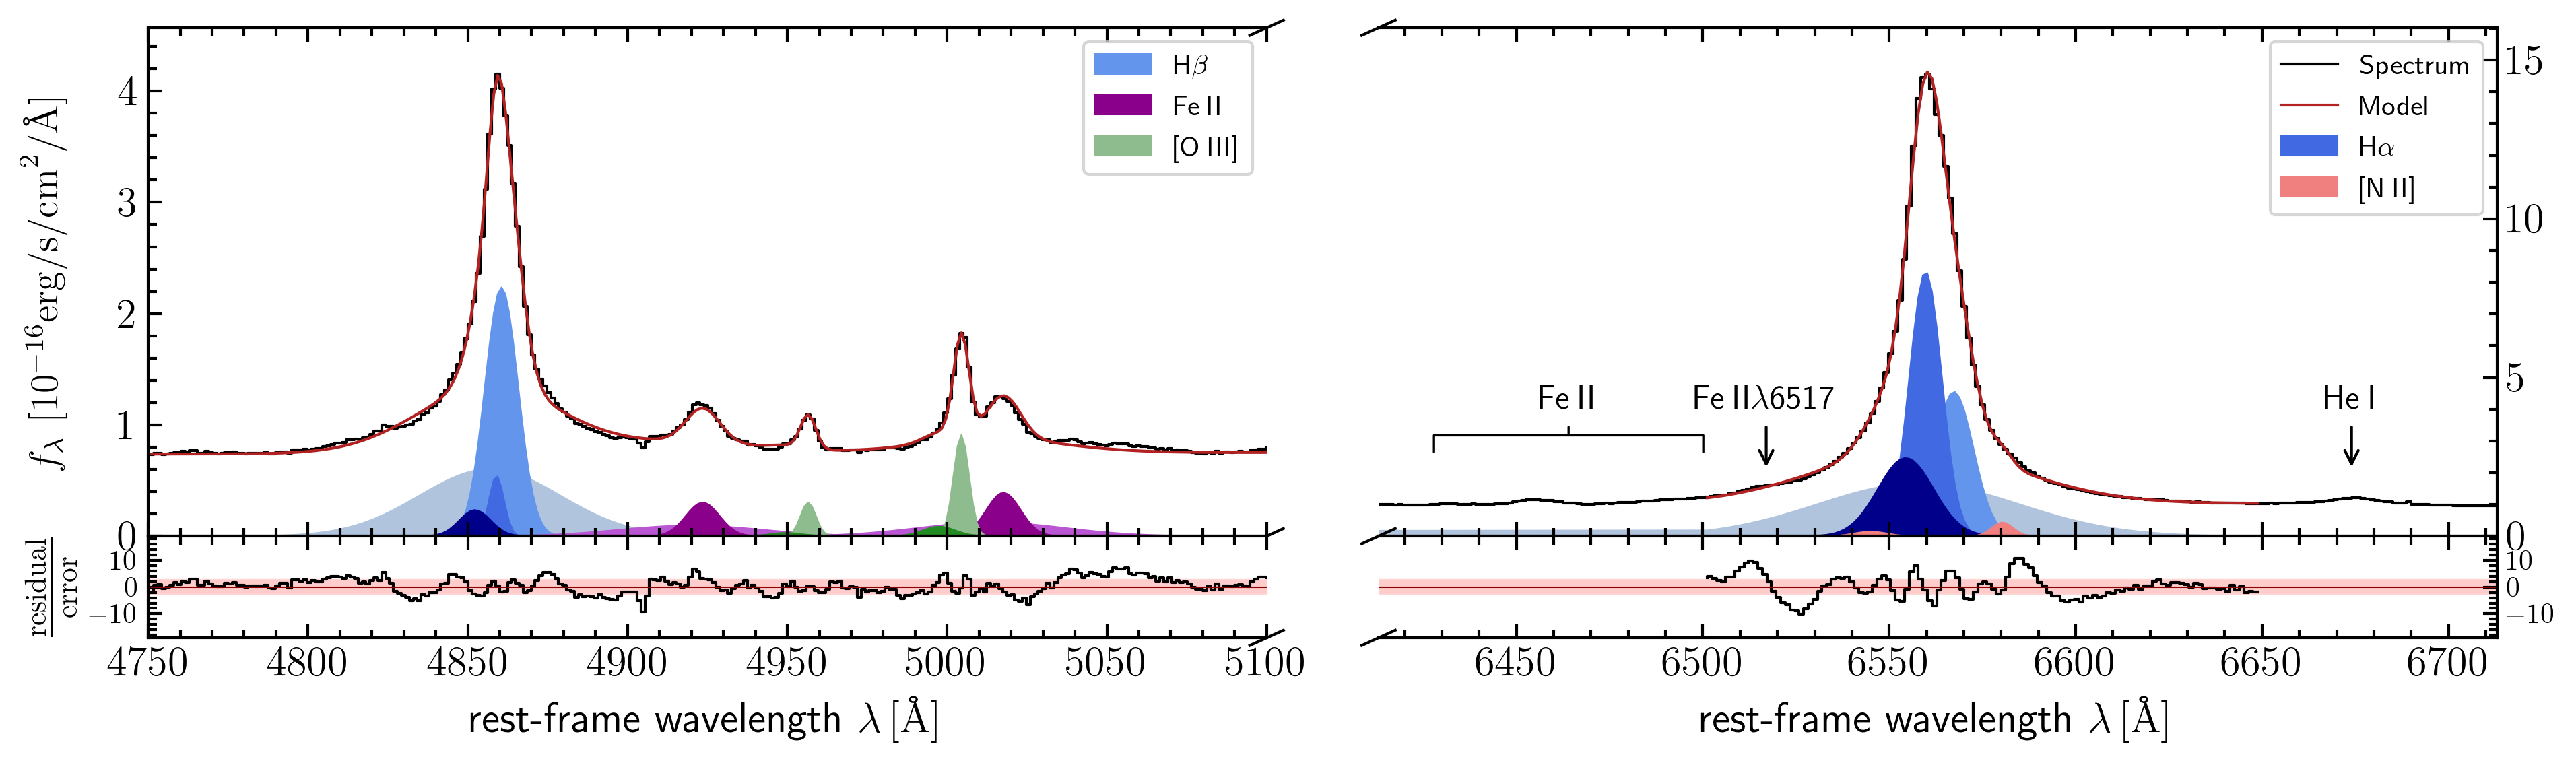

In [10]:
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec_deblended/Data/'

cz = 4913.4
redshift=cz/3e5

dirname1 = 'HE0227-0913/'
objectname='Mrk1044'
df = pd.read_csv(root+dirname1+'Mrk1044_AGN_spectrum_1x1_px.csv')
param_init_file = 'Data/HE0227-0913/Mrk1044.central_fit.Hb.fits'

x = np.array(df['wvl'])/(1+cz/3e5)
y = np.array(df['flux'])
dy = np.array(df['dflux'])


fit_spectrum = Fit_Spectrum(x,y,dy,param_init_file=param_init_file)
fit_spectrum.setup_model_init(fit_spectrum.elines, fit_spectrum.eline_models)
fit_spectrum.run()
        
p = Plot(fit_spectrum)
fig = p.plot_model()
p.annotate_broadlines(fig.axes[1])
fig.savefig('Figures/'+dirname1+objectname+'.QSO_spec.full.png', bbox_inches='tight', dpi=300)

In [82]:
# run MC error estimation
fit_spectrum.run_mc(20)
fit_spectrum.print()

comp. 				  mean λ [A] 	 disp σ [A]     A [ergs-1cm-2A-1]     F [ergs-1cm-2]
 0 	          Hb_core 	 4859.0 ± 0.0 	 2.35 ± 0.02 	 0.55 ± 0.04 	 1.28 ± 0.08  
 1 	    OIII4959_core 	 4956.5 ± 0.0 	 2.39 ± 0.02 	 0.31 ± 0.00 	 0.73 ± 0.01  
 2 	    OIII5007_core 	 5004.4 ± 0.0 	 2.42 ± 0.02 	 0.92 ± 0.01 	 2.23 ± 0.03  
 3 	        Hb_medium 	 4860.6 ± 0.1 	 5.20 ± 0.04 	 2.24 ± 0.02 	 11.65 ± 0.15  
 4 	  FeII4924_medium 	 4923.5 ± 0.1 	 5.27 ± 0.04 	 0.30 ± 0.00 	 1.59 ± 0.02  
 5 	  FeII5018_medium 	 5017.6 ± 0.1 	 5.37 ± 0.04 	 0.39 ± 0.00 	 2.09 ± 0.03  
 6 	         Hb_broad 	 4856.9 ± 0.2 	 22.01 ± 0.20 	 0.60 ± 0.01 	 13.31 ± 0.26  
 7 	   FeII4924_broad 	 4919.8 ± 0.2 	 22.29 ± 0.20 	 0.10 ± 0.00 	 2.18 ± 0.07  
 8 	   FeII5018_broad 	 5013.9 ± 0.2 	 22.72 ± 0.21 	 0.13 ± 0.00 	 2.86 ± 0.09  
 9 	          Hb_wing 	 4852.3 ± 0.0 	 4.77 ± 0.50 	 0.23 ± 0.02 	 1.10 ± 0.16  
 10 	    OIII4959_wing 	 4949.7 ± 0.0 	 4.87 ± 0.51 	 0.03 ± 0.00 	 0.14 ± 0.02  
 11 	    OIII5007_wing 	 4

<ipython-input-79-b26e458c7a55>:382: RuntimeWarning: invalid value encountered in sqrt
  disp = np.sqrt(stddev**2 - res**2)/dict_rf[eline] * 3e5


 0    core         Hb     -144 ±    2       nan ±  1
 1    core   OIII4959     -144 ±    2       nan ±  1
 2    core   OIII5007     -144 ±    2       nan ±  1
 3  medium         Hb      -48 ±    4       281 ±  2
 4  medium   FeII4924      -48 ±    4       282 ±  2
 5  medium   FeII5018      -48 ±    4       284 ±  2
 6   broad         Hb     -272 ±   11      1349 ± 12
 7   broad   FeII4924     -272 ±   11      1350 ± 12
 8   broad   FeII5018     -272 ±   11      1350 ± 12
 9    wing         Hb     -560 ±    0       251 ± 31
10    wing   OIII4959     -560 ±    0       253 ± 31
11    wing   OIII5007     -560 ±    0       253 ± 31
12    core         Ha     -140 ±    0       165 ± 17
13    core    NII6548     -140 ±    0       165 ± 17
14    core    NII6583     -140 ±    0        61 ± 51
15    core    SII6716     -140 ±    0       167 ± 17
16    core    SII6731     -140 ±    0       167 ± 17
17  medium         Ha      206 ±  168       212 ± 81
18   broad         Ha     -232 ±   13      123

In [83]:
# save line parameters
fit_spectrum.write_eline_table(output='Data/'+dirname1 +objectname+'.central_fit.full.fits')

# save [O III] residuals
fit_spectrum.write_OIIIwing_spec('Data/'+dirname1+objectname+'_OIII_residuals.csv')